In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
os.chdir(project_root)  # 👈 this changes the working directory
sys.path.append(project_root)

print("New working directory:", os.getcwd())

New working directory: C:\Users\Atharva Kulkarni\Desktop\SIEM\SIEM project\AI-driven-SIEM-System


In [3]:
from src.utils.config_loader import load_config
config = load_config("configs/log-anomaly-detection.yml")
print("Raw data path:", config["data"]["raw_data_path"])

Raw data path: data/logs/raw/



[1/6] Loading and Preprocessing Data...
Encoding categorical columns...


Encoding: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


Imputing missing values...
Scaling features...

[2/6] Training Isolation Forest...

[5/6] Isolation Forest Results:
Anomalies detected: 1270 out of 25456 samples
[6/6] Plotting Isolation Forest Anomaly Scores...


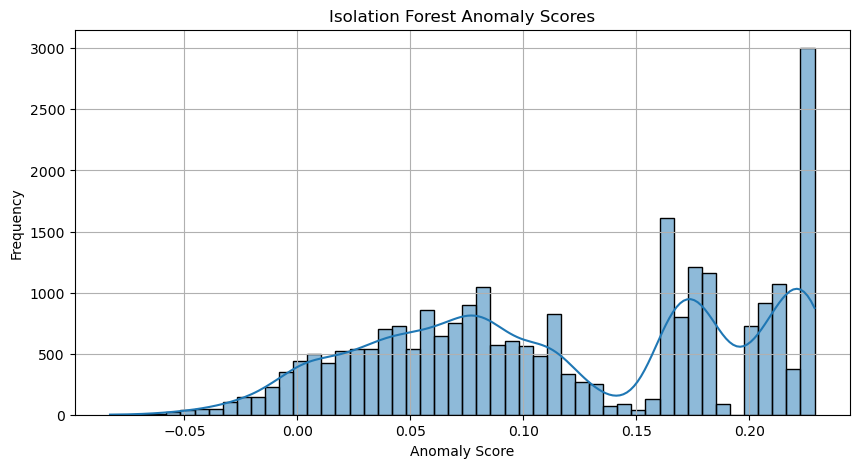


[3/6] Training One-Class SVM...

[5/6] One-Class SVM Results:
Anomalies detected: 1274 out of 25456 samples
[6/6] Plotting One-Class SVM Anomaly Scores...


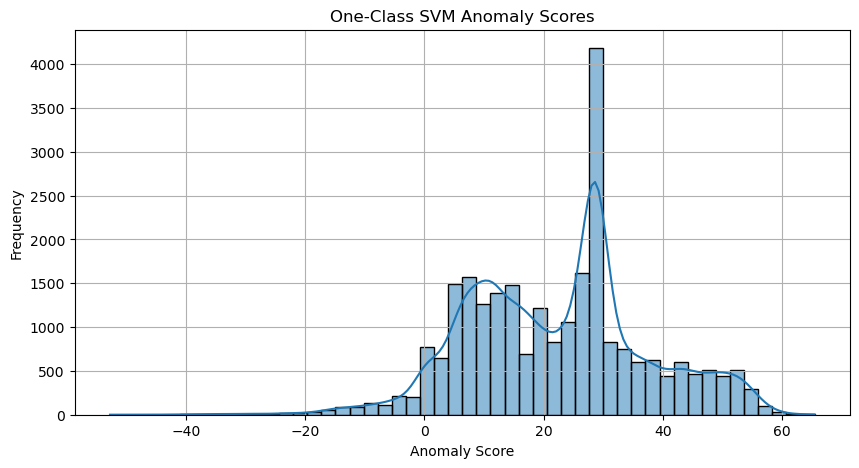


[4/6] Applying PCA for Anomaly Detection...

[5/6] PCA-Based Results:
Anomalies detected: 1273 out of 25456 samples
[6/6] Plotting PCA Anomaly Scores...


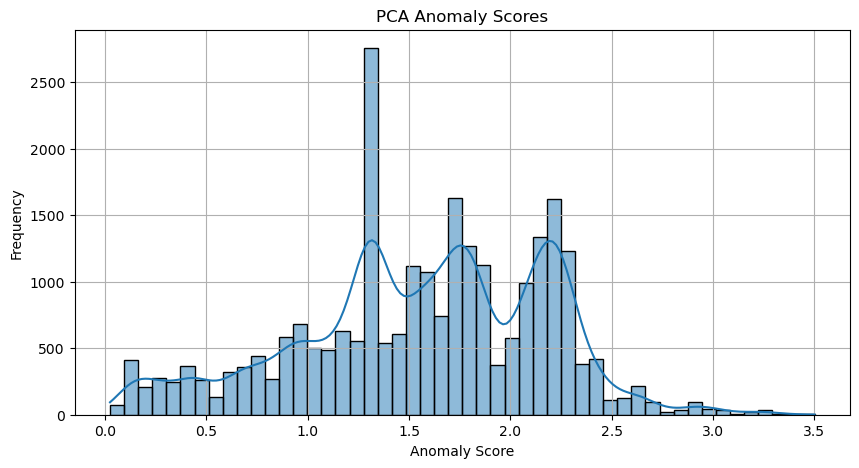

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

# Step 1: Load and preprocess dataset
def load_and_preprocess(path):
    print("\n[1/6] Loading and Preprocessing Data...")
    df = pd.read_csv(path)

    # Drop columns that are not useful for modeling
    drop_cols = ["LineId", "Time", "Content", "EventTemplate"]
    df = df.drop(columns=drop_cols)

    # Encode categorical columns
    categorical_cols = ["Month", "Level", "Component", "EventId"]
    print("Encoding categorical columns...")
    for col in tqdm(categorical_cols, desc="Encoding"):
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
        time.sleep(0.1)  # Optional: To visualize tqdm better for small datasets

    # Impute missing values
    print("Imputing missing values...")
    imputer = SimpleImputer(strategy="mean")
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # Normalize/Scale the data
    print("Scaling features...")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df.columns)

    return df_scaled

# Step 2: Isolation Forest
def apply_isolation_forest(X):
    print("\n[2/6] Training Isolation Forest...")
    model = IsolationForest(contamination=0.05, random_state=42)
    preds = model.fit_predict(X)
    scores = model.decision_function(X)
    return preds, scores

# Step 3: One-Class SVM
def apply_one_class_svm(X):
    print("\n[3/6] Training One-Class SVM...")
    model = OneClassSVM(kernel="rbf", nu=0.05, gamma='scale')
    preds = model.fit_predict(X)
    scores = model.decision_function(X)
    return preds, scores

# Step 4: PCA
def apply_pca_anomaly(X, n_components=2):
    print("\n[4/6] Applying PCA for Anomaly Detection...")
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    scores = np.linalg.norm(X_pca, axis=1)
    threshold = np.percentile(scores, 95)
    preds = np.where(scores > threshold, -1, 1)
    return preds, scores

# Step 5: Evaluation function
def evaluate(preds, scores, name):
    print(f"\n[5/6] {name} Results:")
    print(f"Anomalies detected: {(preds == -1).sum()} out of {len(preds)} samples")

# Step 6: Plot function
def plot_scores(scores, title):
    print(f"[6/6] Plotting {title}...")
    plt.figure(figsize=(10, 5))
    sns.histplot(scores, bins=50, kde=True)
    plt.title(title)
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Main execution
if __name__ == "__main__":
    path = "data/logs/processed/Linux.log_structured.csv"
    X = load_and_preprocess(path)

    # Isolation Forest
    iso_preds, iso_scores = apply_isolation_forest(X)
    evaluate(iso_preds, iso_scores, "Isolation Forest")
    plot_scores(iso_scores, "Isolation Forest Anomaly Scores")

    # One-Class SVM
    svm_preds, svm_scores = apply_one_class_svm(X)
    evaluate(svm_preds, svm_scores, "One-Class SVM")
    plot_scores(svm_scores, "One-Class SVM Anomaly Scores")

    # PCA
    pca_preds, pca_scores = apply_pca_anomaly(X)
    evaluate(pca_preds, pca_scores, "PCA-Based")
    plot_scores(pca_scores, "PCA Anomaly Scores")


In [5]:
from collections import Counter

# Combine labels
combined = pd.DataFrame({
    'IsolationForest': iso_preds,
    'OneClassSVM': svm_preds,
    'PCA': pca_preds
})

# Mark consensus anomalies (detected by ≥2 models)
combined['anomaly_votes'] = (combined == -1).sum(axis=1)
consensus_anomalies = combined[combined['anomaly_votes'] >= 2]
print(f"Consensus anomalies (>=2 models agree): {len(consensus_anomalies)}")


Consensus anomalies (>=2 models agree): 971
